This version (3): improvements including 
1. Tapered Bandpass

This captures an FM radio signal of a specified duration, demodulates it in a very simple fashion, and plays the audio over the computer's speaker.

This version (1b) fixes a bug: new arrays were not being allocated when we attempted to copy data to a new buffer after each processing step. This version uses the copy module to make sure new buffers are created whenever values are assigned to a new buffer variable. 

In [10]:
4+2 # Test if kernel is running

6

In [11]:
import time
import numpy as  np
import matplotlib.pyplot as plt
import sounddevice as sd
from copy import copy
np.set_printoptions(precision=2)

In [14]:
# Close old SDR instance
# Need to do this before you can adjust sampling frequency
# Drivers must be installed for this to work
# If this gives an error (eg because another program is controlling
# the SDR), close the other program and restart this kernel
from rtlsdr import RtlSdr 
# Close previous instances of the sdr object
try: 
    sdr.close()
    print("Closed old SDR")
except NameError:
   print("No SDR instance found")

Closed old SDR


In [15]:
sdr = RtlSdr() # Create a new sdr object (by keeping this in 
               # the block above can be used to close sdr without
               # creating a new sdr instance, which you might want to
               # do when switching to a new program
               # If this fails, try 
               # (1) Unpluging and re-inserting the RTL SDR device
               # (2) running close block above
               # (3) closing other programs that may be using SDR
               # (4) restarting this kernel

In [16]:
#Q2
# Making samples per sec a multiple of 256 means that if
# we sample for simple multiples of 1 s, our number of samples
# will be multiples of 256, which is a requirement
# fsps = 3*256*256*16 # = 3145728 about 3Msps...SEEMS to work (but see below)...3.5Msps and above gives error
# Note that while 3Msps does seem to work, the time it takes to collect the samples
# ends up being a lot longer than it should...maybe it's doing some kind of
# oversampling to get the values for high sampling rates?
#fsps = 256*256*16 # = 1048576 ... about 1Msps...works
fsps = 2*256*256*16 # =  ... about 2Msps...works
faudiosps =48000 # audio sampling frequency (for output)

fc = 94.9e6 # KUOW Seattle
#fc = 89.7e6 # KWWS Walla Walla
#fc = 90.3e6 # Some Seattle station
#fc = 89.7e6 # adjacent to 89.7 for validation
#fc = 89.8e6 # adjacent to 89.7 for validation

#fc = 92.6e6 # adjacent to spanish language station at 92.5

# For SMArt XTR...small gap at 1100MHz
#fcmin = 55e6
#fcmax = 2300e6

#fcmin = 88e6 # lowest freq in US FM band
#fcmax = 108e6 # highest freq in US FM band

# specify sampling frequency
dt = 1.0/fsps # time step size between samples
nyquist = fsps /2.0


#Tmax = 10.0       # 5 s
#Tmax = 5.0       # 5 s
Tmax = 2.5        # 2.5 s
#Tmax = 1.0        # 1 s
#Tmax = 0.125     # 1/8  s = 125ms
#Tmax = 0.0625    # 1/16 s = 62 ms 
#Tmax = 0.03125   # 1/32 s = 31 ms
#Tmax = 0.015625  # 1/64 s = 16 ms
#Tmax = 0.0078125 # 1/128s = 7.8ms
#Tmax = 0.00390625 # 1/256s = 3.9ms

N = round(fsps*Tmax) # N must be a multiple of 256
print("The number of samples to collect, N= ",N)

sdr.sample_rate = fsps 
sdr.center_freq = fc

print("The valid gains are")
print(sdr.valid_gains_db)
#sdr.gain = 'auto'
sdr.gain = 42.0 # This is max, according to sdr.valid_gains_db
print("We are using ")
print("Gain (0==auto)  : ", sdr.gain)
print("Sample Rate     : ", sdr.sample_rate)
print("Center frequency: ", sdr.center_freq)

The number of samples to collect, N=  5242880
The valid gains are
[-1.0, 1.5, 4.0, 6.5, 9.0, 11.5, 14.0, 16.5, 19.0, 21.5, 24.0, 29.0, 34.0, 42.0]
We are using 
Gain (0==auto)  :  42.0
Sample Rate     :  2097152.0
Center frequency:  94900000


In [17]:
# to be cut

# Collect some noise (to be used when measuring Signal to Noise
# ratio)
noisesamples = ((np.zeros((N))+1j)-1j) # Trick it into being an array of complex zeros
fnoise = 80e6
sdr.center_freq = fnoise # outside of FM band...should be empty
print("Sampling with center frequency ", fnoise, " for ", Tmax, " seconds")
print("Frequency spans from ", (fnoise-nyquist)/1e6," to ", (fnoise+nyquist)/1e6,"MHz")
print("SDR gain:", sdr.gain)
noisesamples = sdr.read_samples(N) # Collect N samples...N must be multiple of 256
#noisepower = np.sum(np.real(noisesamples*noisesamples.conjugate()))
#noisepowerperhz = noisepower / nyquist
#noisepowerperbin = noisepower / len(noisesamples)
#print("Total noise power (from time domain) =", noisepower)
#print("Total noise power / Hz (from time domain) = ", noisepowerperhz)
#print("Total noise power / bin (from time domain) = ", noisepowerperbin)

noisespectrum = np.fft.fftshift(np.fft.fft(noisesamples))
noisepowerfd = np.sum(np.real(noisespectrum*noisespectrum.conjugate()))
noisepowerperhzfd = noisepowerfd / nyquist
noisepowerperbinfd = noisepowerfd / len(noisesamples)

print("Total noise power (from freq domain) =", noisepowerfd)
print("Total noise power / Hz (from freq domain) = ", noisepowerperhzfd)
print("Total noise power / bin (from freq domain) = ", noisepowerperbinfd)


sdr.center_freq = fc # set it back to main frequency of interest


Sampling with center frequency  80000000.0  for  2.5  seconds
Frequency spans from  78.951424  to  81.048576 MHz
SDR gain: 42.0
Total noise power (from freq domain) = 100259372107.98308
Total noise power / Hz (from freq domain) =  95614.78815840061
Total noise power / bin (from freq domain) =  19122.95763168012


In [18]:
#***
# Collect samples
samples = ((np.zeros((N))+1j)-1j) # Trick it into being an array of complex zeros
print("Sampling with center frequency ", fc, " for ", Tmax, " seconds")
sdr.center_freq = fc
print("Frequency spans from ", (fc-nyquist)/1e6," to ", (fc+nyquist)/1e6,"MHz")

print("SDR gain:", sdr.gain)

RF_record_start_time = time.time()
samples = sdr.read_samples(N) # Collect N samples...N must be multiple of 256end_time = time.time()
RF_record_end_time = time.time()
RF_record_duration_actual = RF_record_end_time - RF_record_start_time
print("Actual time duration of RF recording: ",RF_record_duration_actual)
print("Commanded samples per second=", fsps)
print("Actual samples per second= ", N/RF_record_duration_actual)
print("Percentage deviation= ", (-100*(fsps-(N/RF_record_duration_actual))/fsps))

Sampling with center frequency  94900000.0  for  2.5  seconds
Frequency spans from  93.851424  to  95.948576 MHz
SDR gain: 42.0
Actual time duration of RF recording:  2.5921669006347656
Commanded samples per second= 2097152
Actual samples per second=  2022585.813712895
Percentage deviation=  -3.5555928367188017


For band from  93.851424  to  95.948576 MHz,
 max is 19002989882.144657  at  94.89982059996578 MHz (index  2620991 )


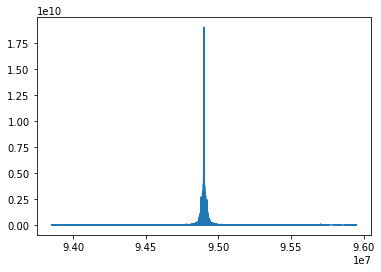

In [23]:
#***
# Compute and plot the spectrum for the samples just collected
freqs = np.zeros((N))
spectrum = ((np.zeros((N))+1j)-1j)
maxval = 0.0
maxind = 0.0

#plt.figure(figsize=(16,12))
plt.figure()
spectrum = np.fft.fftshift(np.fft.fft(samples))
maxval = np.amax(np.abs(spectrum))
maxindi = np.argmax(np.abs(spectrum))
freqs = np.linspace(fc-nyquist,fc+nyquist,len(spectrum))
plt.plot(freqs,np.abs(spectrum*spectrum.conjugate()))
#plt.plot(freqs/1e6,10*np.log10(np.real(spectrum*spectrum.conjugate())/noisepowerperbinfd))
#plt.title("Signal-to-Noise ratio, in dB")
print("For band from ", (fc-nyquist)/1e6, " to ",(fc+nyquist)/1e6, "MHz,")
#print(" max is", round(10*np.log10((maxval**2)/noisepowerperbinfd)), "dB, at ", freqs[maxindi]/1e6, "MHz (index ", round(maxindi),")")
print(" max is", maxval**2, " at ", freqs[maxindi]/1e6, "MHz (index ", round(maxindi),")")

In [19]:
#      zw         mw        zw
#   --------+++++++++++++--------
#          -fc          fc
#  -nyq           0          +nyq
# returns a length N vector consisting  
# ones in the middle, padded by zeros on the left and right
# fcutoff is the one-sided cutoff frequency
# so if fcutoff is 100kHz, the pass band will extend from 
# bin N/2 - 100kHz to bin N/2 + 100kHz
def bandpassmask(N,fsps,fcutoff):
    fnyq = fsps/2.0
    fcutoff_nyq = fcutoff / fnyq 

    midwidth = round(fcutoff_nyq*N)
    zerowidth = int((N-midwidth)/2)
    print("N= ", N, " fsps= ",fsps, " fcutoff=", fcutoff, " fcutoff_nyq= ",fcutoff_nyq," midwidth= ", midwidth, " zerowidth= ", zerowidth)
    res = np.concatenate((np.zeros(zerowidth),np.ones(midwidth),np.zeros(zerowidth)))
    return(res)

In [20]:
# Re-doing with more standardized terminology of
# stopband width, passband width, passband full width (double sided)
#
#      sbw        pbfw       sbw
#   --------+++++++++++++--------
#           -fc          fc
#  -nyq            0             +nyq
# returns a length N vector consisting  
# ones in the middle, padded by zeros on the left and right
# fcutoff is the one-sided cutoff frequency
# so if fcutoff is 100kHz, the pass band will extend from 
# bin N/2 - 100kHz to bin N/2 + 100kHz
def bandpassmask2(N,fsps,fcutoff):
    fcutoff_n = fcutoff / fsps # fcutoff, normalized

    pbfw = round(2*fcutoff_n*N)
    sbw = int((N-pbfw)/2)
    print("N= ", N, " fsps= ",fsps, " fcutoff=", fcutoff, " fcutoff_n= ",fcutoff_n," pbfw= ", pbfw, " sbw= ", sbw)
    res = np.concatenate((np.zeros(sbw),np.ones(pbfw),np.zeros(sbw)))
    print("total= ",pbfw+sbw+sbw)
    return(res)

In [21]:
# Tapered bandpass
# stopband width, passband width, passband full width (double sided)
#
#      sbw   xbw      pbfw     xbw    sbw
#   --------00000+++++++++++++00000--------
#                -fc        fc
#  -nyq                 0             +nyq
# returns a length N vector consisting  
# ones in the middle, padded by zeros on the left and right
# fcutoff aka fc is the one-sided cutoff frequency...the edge of the passband
# xbw is transition band width
# sbw is stop band width
def taperedbandpassmask(N,fsps,fcutoff,xwidth):
    fcutoff_n = fcutoff / fsps # fcutoff, normalized
    xwidth_n = xwidth / fsps # transition width, normalized
    
    pbfw = round(2*fcutoff_n*N)
    xbw = round(xwidth_n*N)
    sbw = int((N-pbfw-xbw-xbw)/2)
    print("N= ", N, " fsps= ",fsps, " fcutoff=", fcutoff, " fcutoff_n= ",fcutoff_n," xwidth= ",xwidth," xwidth_n= ",xwidth_n," pbfw= ", pbfw, " sbw= ", sbw)
    res = np.concatenate((np.zeros(sbw), #
                          np.arange(0.0,1.0,1.0/xbw), #
                          np.ones(pbfw), #
                          np.arange(1.0,0.0,-1.0/xbw), #
                          np.zeros(sbw)))
    print("N = ",N)
    print("xbw= ",xbw)
    print("total sbw+xbw+pbfw+xbw+sbw= ",sbw+xbw+pbfw+xbw+sbw)
    print("len(arange) = ", len(np.arange(0.0,1.0,1.0/xbw)))
    return(res)

N=  5242880  fsps=  2097152  fcutoff= 200000  fcutoff_n=  0.095367431640625  xwidth=  200000  xwidth_n=  0.095367431640625  pbfw=  1000000  sbw=  1621440
N =  5242880
xbw=  500000
total sbw+xbw+pbfw+xbw+sbw=  5242880
len(arange) =  500000


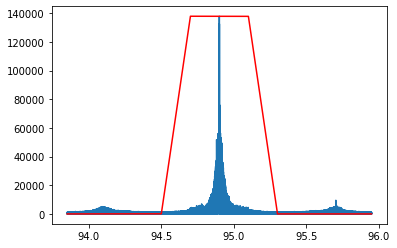

In [24]:
# Create and plot the bandpass mask
fcutoff = 200000 # Cutoff frequency of filter 100kHz
#bpm = bandpassmask2(N,fsps,fcutoff) # create the bandpass mask
bpm = taperedbandpassmask(N,fsps,fcutoff,200000)
plt.figure()
height = np.max(np.abs(spectrum))
plt.plot(freqs/1e6,np.abs(spectrum))
plt.plot(freqs/1e6,height*bpm,'r')

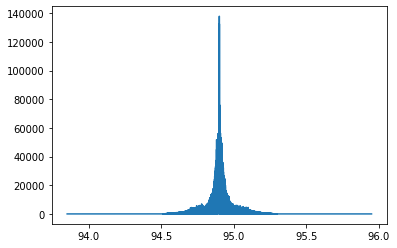

In [25]:
#***
# Filter by applying frequency mask to spectrum
filteredspectrum = spectrum * bpm
plt.plot(freqs/1e6,np.abs(filteredspectrum))

In [26]:
#***
# Convert masked spectrum back to time domain to get filtered signal 
filteredsignal = np.fft.ifft(np.fft.fftshift(filteredspectrum)) # Good results

# For validation, also convert from time back to freq to make sure 
# we didn't mess something up (ie to make sure we get back spectrum)
# we started with
#validatefilteredsignal = np.fft.fftshift(np.fft.fft(filteredsignal))
#plt.figure()
#plt.plot(np.abs(validatefilteredsignal))

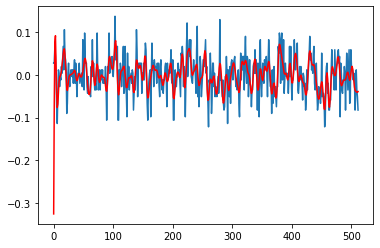

In [27]:
# Compare time domain view of filtered and un-filtered signal
plt.figure()
plt.plot(np.real(samples[0:512]))
plt.plot(np.real(filteredsignal[0:512]),'r')

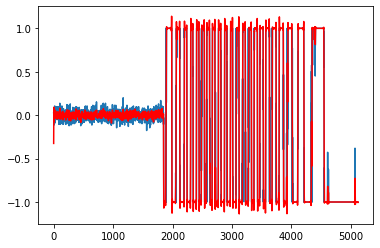

In [28]:
plt.figure()
plt.plot(np.real(samples[0:5120]))
plt.plot(np.real(filteredsignal[0:5120]),'r')

# Find $\frac{d\theta}{dt},$ the derivative of the phase $\theta$

First find the phase $\theta$ from the complex signals

In [29]:
#***
#theta = np.angle(filteredsignal)
theta = np.arctan2(filteredsignal.imag,filteredsignal.real)

In [30]:
abssignal = np.abs(filteredsignal)
meanabssignal = np.mean(abssignal)
thetasquelched = copy(theta)
filteredsquelched = copy(filteredsignal)
for i in range(N):
    if (abssignal[i]<(meanabssignal/3.0)):
        filteredsquelched[i] = 0.0
        thetasquelched[i] = 0.0

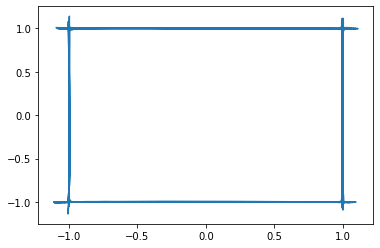

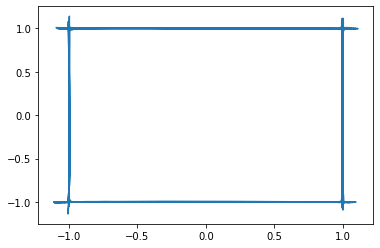

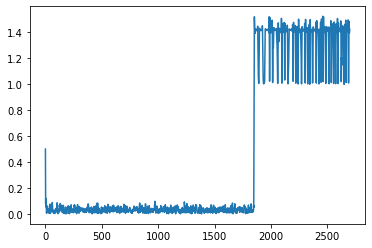

In [31]:
mins = int(2.1e3)
maxs = int(2.7e3)
alphaval = 1.0
#alphaval = 0.005
plt.figure()
#plt.plot(filteredsignal[mins:maxs].real,filteredsignal[mins:maxs].imag,'.',alpha=alphaval) # point
plt.plot(filteredsignal[mins:maxs].real,filteredsignal[mins:maxs].imag,alpha=alphaval) # line
plt.figure()
#plt.plot(filteredsquelched[mins:maxs].real,filteredsquelched[mins:maxs].imag,'.',alpha=alphaval) # point
plt.plot(filteredsquelched[mins:maxs].real,filteredsquelched[mins:maxs].imag,alpha=alphaval) # line
plt.figure()
plt.plot(np.abs(filteredsignal[0:maxs]))

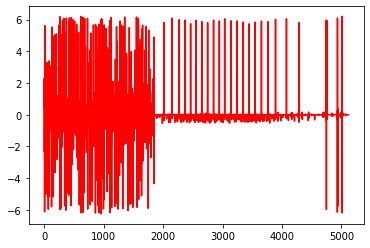

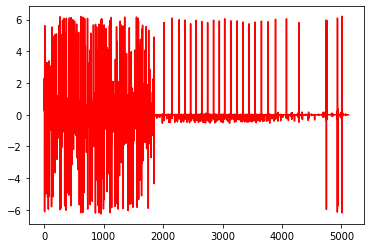

In [32]:
# No squelching version
# deriv (theta plus 0)
#derivthetap0 = np.convolve([1,-1],thetasquelched,'same')
derivthetap0 = np.convolve([1,-1],theta,'same')
derivthetapp = np.convolve([1,-1],(theta+np.pi) % (2*np.pi),'same')
plt.figure()
plt.plot(derivthetap0[0:5120],'r')
plt.figure()
plt.plot(derivthetapp[0:5120],'r')

In [33]:
derivthetap0[100:110]-derivthetapp[100:110]

array([ 1.11e-16,  0.00e+00,  1.67e-16, -3.89e-16,  1.11e-16,  1.11e-16,
       -1.11e-16,  1.11e-16,  0.00e+00,  0.00e+00])

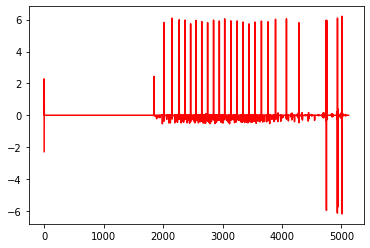

In [34]:
# Squelching version...
# deriv (theta plus 0)
derivthetap0 = np.convolve([1,-1],thetasquelched,'same')
derivthetapp = np.convolve([1,-1],(thetasquelched+np.pi) % (2*np.pi),'same')
plt.figure()
plt.plot(derivthetap0[0:5120],'r')

In [35]:
# The 0, +pi comparison method
# deriv (theta plus pi)
derivtheta = np.zeros(len(derivthetap0))
for i in range(len(derivthetap0)):
    if (abs(derivthetap0[i])<abs(derivthetapp[i])):
        derivtheta[i] = derivthetap0[i] 
    else:
        derivtheta[i] = derivthetapp[i] 
cdtheta = copy(derivtheta)

In [36]:
spikethresh = 2
# First let's look in detail at the first few spikes
for i in range(1000):
  if (abs(derivtheta[i]) > (spikethresh)):
    print(i,"  ",derivtheta[i])

1    2.2824159956632117


In [37]:
# and the last spikes
for i in range(len(derivtheta)-1000,len(derivtheta)):
  if (abs(derivtheta[i]) > (spikethresh)):
    print(i,"  ",derivtheta[i])

5242021    -6.188200653612685
5242023    6.220620821875929
5242026    -6.134075934398538
5242074    6.16171015866106
5242472    -5.890286629902752
5242484    6.111899073747432
5242486    -6.080268210322105
5242519    6.13793941519247
5242541    -5.9676803983859905
5242627    5.94835776514971
5242630    -5.994890973900299
5242635    5.875362607924833
5242703    -6.248370975198393
5242704    6.159667343383418
5242716    -6.155836231852044
5242718    6.142281182875806
5242780    -5.931065294041449


Pick threshold (spikethresh) large enough that the phase-wrap spikes are isolated...that will mean we can remove them nicely by averaging their neighbors. (Why wouldn't they be? Maybe noise could cause some weird things to happen, like bouncing back and forth across the $0-2 \pi$ phase wrap boundary a few times in a row? 

In [38]:
#***
#cdtheta = copy(derivthetap0) # Cleaned derivative of theta
cdtheta = copy(derivtheta) # Cleaned derivative of theta
for i in range(1,len(derivtheta)-1):
    if (abs(derivtheta[i])>spikethresh):
        cdtheta[i] = (derivtheta[i-1]+derivtheta[i+1])/2.0

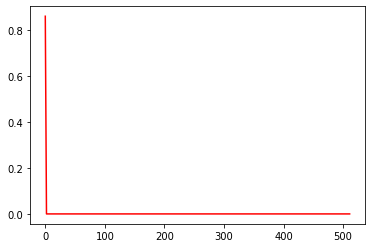

In [39]:
plt.figure()
#plt.plot(derivtheta[0:512],'b')
plt.plot(cdtheta[0:512],'r')

Note: The y-scale on figure above ("cleaned") is -.2 to +.2...original un-cleaned y-scale was -2pi to +2pi...throwing away the wrap artifacts made a huge impact on our signal (at least when viewed using a plot with a y scale that is auto-selected to the max values). The next plots show the difference between the cleaned and un-cleaned signals once these outliers have been removed.

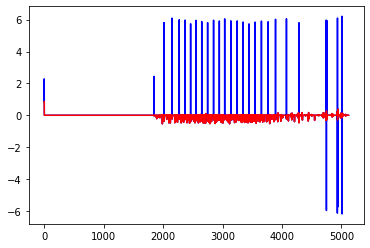

In [40]:
plt.figure()
plt.plot(derivtheta[0:5120],'b')
plt.plot(cdtheta[0:5120],'r')

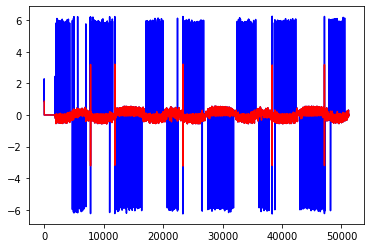

In [41]:
plt.figure()
plt.plot(derivtheta[0:51200],'b')
plt.plot(cdtheta[0:51200],'r')

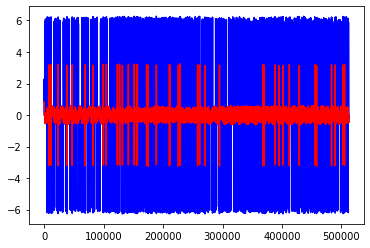

In [42]:
plt.figure()
plt.plot(derivtheta[0:512000],'b')
plt.plot(cdtheta[0:512000],'r')

The plot above shows that the cleaning had a huge effect!

In [ ]:
#skip
FTderivtheta=np.fft.fftshift(np.fft.fft(derivtheta))
plt.figure
plt.plot(freqs/1e6,np.abs(FTderivtheta))

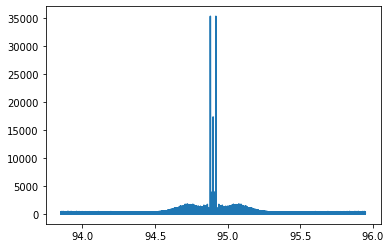

In [43]:
FTcdtheta=np.fft.fftshift(np.fft.fft(cdtheta))
plt.figure
plt.plot(freqs/1e6,np.abs(FTcdtheta))

In the frequency domain the cleaned & uncleaned signals look drastically different! Those spikes were really messing things up.

### Downsampling
Our RF samples are about 1Msps (one million samples per second)...our audio sub-system only plays about 48000 sps...so we need to downsample, ie throw away samples. First we'll look at Python notation for downsampling, and then we'll figure out how many samples we need to throw away

In [44]:
# How much do we need to downsample?
# Let's figure out the required downsampling factor
# For example, suppose we need to turn 1048576 sps into 48000 sps
# then the downsampling ratio = 1048576/48000, which is about 22
dsf = round(fsps/faudiosps) # round(1048576/48000)=22
print("Down sampling factor is", dsf)

Down sampling factor is 44


In [45]:
#*** DownSampled Cleaned Derivative of Theta
dscdtheta = cdtheta[::dsf] # downsample by 22 (or whatever dsf is)

In [48]:
dscdtheta2 = copy(dscdtheta)
for i in range(len(dscdtheta2)):
    dscdtheta2[i] = np.sum(cdtheta[i*dsf:(i+1)*dsf])/dsf
print("Length before downsampling: ",len(cdtheta))
print("Length after downsampling : ",len(dscdtheta2))
dscdtheta = copy(dscdtheta2)

Length before downsampling:  5242880
Length after downsampling :  119157


In [49]:
# Let's figure out the horizontal scale of the FT of the audio
faudionyquist = faudiosps/2.0
freqsaudio = np.linspace(-faudionyquist,+faudionyquist,len(dscdtheta))

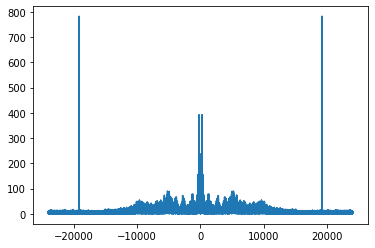

In [50]:
# FourierTransform of DownSampled Cleaned Derivative of Theta
FTdscdtheta=np.fft.fftshift(np.fft.fft(dscdtheta))
plt.figure
plt.plot(freqsaudio,np.abs(FTdscdtheta))

In [53]:
# Play Audio
#faudiosps defined at top (eg 48000)
dt_audio = 1/faudiosps
myaudio = dscdtheta
print("Commanded time duration of RF recording (TMAX):", Tmax)
print("Expected time duration of audio based on commanded audio sample duration: ",len(dscdtheta)*dt_audio)
start_time = time.time()
sd.play(10*myaudio,faudiosps,blocking=True)
end_time = time.time()
time_actual = end_time-start_time
print("Actual time duration to play audio: ",time_actual)


Commanded time duration of RF recording (TMAX): 2.5
Expected time duration of audio based on commanded audio sample duration:  2.4824375
Actual time duration to play audio:  2.6104440689086914


In [1]:
x = 1+1j


In [5]:
print(x)
x*x.conjugate()

(1+1j)


(2+0j)

In [7]:
abs(x)**2

2.0000000000000004

In [9]:
x.imag

1.0

In [ ]:
n